In [1]:
# Imports and plotting setups
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import math

import math_funcs

from scipy.special import loggamma, factorial, gamma
from decimal import Decimal
import decimal

from antenna_patterns import antenna
from transmission_reflection_coefficients import transmissivity_fBm, reflectivity_fBm, fresnel_coefficients
from T_B_Europan_sky import angle_grid, T_B_sub_jovian_point, T_B_anti_jovian_point, T_B_anti_orbital_point
from pucks_to_penetrate_cryosphere import europa_ice_model, mission_model, calc_path_loss

from scipy.constants import (
    epsilon_0,   # Permittivity of free space (vacuum)
    mu_0,        # Permeability of free space (vacuum)
    c,           # Speed of light in vacuum
    #e,           # Elementary charge
    #h,           # Planck constant
    #hbar,        # Reduced Planck constant (h-bar)
    k,           # Boltzmann constant
    #G,           # Newtonian constant of gravitation
    #m_e,         # Electron mass
    #m_p,         # Proton mass
    #m_n,         # Neutron mass
    #alpha,       # Fine-structure constant
    eV,          # Electron volt
)

T_u = 104#K
T_l = 230#K
T_melt = 273.13 #K
T_conv = 251.6 #K
D_cond = 10.4e3 #m
D_phi = 3.2e3 #m
eta_vac = 0.1 #np.arrange(0, 0.3, 0.1)
rho_salt = 1e-5 #np.linspace(1e-3, 4.2e-2, 10)
D_conv = 5.8e3 #m
delta_d = 10#m
H = 0.75 # Surface roughness hurst coefficient
sigma_ref = 0.2# Surface roughness at reference wavelength (at 1m)

In [4]:
def _evaluate_fBm_series(
        sigma_A, H, 
        eta_xy, eta_z,
        tolerance = 1e-5,
        decimal_precision = int(1e3),
        max_n_convergence = 10.0,
        debug = False):
    # Giorgio Franceschetti, Daniele Riccio, 
    # “Chapter 6 - Scattering from Fractional 
    # Brownian Surfaces: Physical-Optics Solution” 
    # in Scattering, Natural Surfaces, and Fractals, 2006

    if H < 0.5:
        raise(ValueError('This series is only valid for H >= 1/2'))

    # Evaluate the series S at 0
    n = 0

    first_fraction = ((-1) ** n) / (2**(2*n) * (factorial(n))**2)
    second_fraction = (eta_xy)**(2*n) / (0.5 * eta_z**2 * sigma_A**2)**((n+1)/H)
    third_factor = gamma((n + 1) / H)

    sum = Decimal(first_fraction*second_fraction*third_factor)
    delta_sum_list = [np.log(first_fraction*second_fraction*third_factor)]
    old_log_factorial = np.log(factorial(n))
    accuracy_overflow = False

    # Evaluate the series S from 1 to max_n_convergence
    # or until the terms is less than tolerance
    for n in np.arange(1.0, max_n_convergence + 1.0, 1):

        new_log_factorial = 2 * np.log(n) + old_log_factorial
        old_log_factorial = new_log_factorial
        kernel =  -2 * n * np.log(2) \
            - new_log_factorial \
                + 2 * n * np.log(eta_xy) \
                    - ((n+1) / H)*np.log(0.5 * eta_z**2 * sigma_A**2) \
                        + loggamma((n + 1) / H)
        
        delta_sum = Decimal(np.e)**Decimal(kernel)
        try:
            sum += Decimal((-1**n)) * delta_sum
        except(BaseException):
            print(sigma_A, H, 
                eta_xy, eta_z, sum, n, delta_sum)
            import sys
            sys.exit(-1)
            
        delta_sum_list.append(kernel)

        if kernel > decimal_precision :
            accuracy_overflow = True

        if n != 0:   
            if tolerance > delta_sum:
                break
    
    # Mask the sum if it exceeded the max n convergence, 
    # or if the decimal precision was not high enough
    terms_to_converge = n

    if terms_to_converge >= max_n_convergence:
        sum = np.nan
        
    if accuracy_overflow:
        sum = np.nan

    return sum, terms_to_converge, accuracy_overflow

In [6]:
sigma_A = 4.083033022841862
H=0.75
eta_xy = 2.299296984739803e-17
eta_z = 0.0

(eta_xy)**(2*1) / (0.5 * eta_z**2 * sigma_A**2)

_evaluate_fBm_series(sigma_A, H, 
        eta_xy, eta_z,)

ZeroDivisionError: float division by zero

In [8]:
theta_i = np.pi/4
theta_s = np.pi/4
phi_s = np.pi
lambda_i = c / (5.373e6 * np.sqrt(2.78)) 
k_i = 2 * np.pi / lambda_i

eta_xy = np.sqrt((k_i * np.sin(theta_s) * np.cos(phi_s) - k_i * np.sin(theta_i))**2 \
                + (k_i * np.sin(theta_s) * np.sin(phi_s))**2)
eta_z = k_i * np.cos(theta_i) + k_i * np.cos(theta_s)

eta_xy, eta_z

(np.float64(0.26552988158417135), np.float64(0.26552988158417135))

In [3]:
theta_i = np.pi/4
epsilon_i_prime = 2.78
epsilon_t_prime = 1
gamma_vv_r = reflectivity_fBm(
    5.373e6,
    epsilon_i_prime,
    epsilon_t_prime, 
    sigma_ref,
    H,
    theta_i, 
    np.pi/4, 
    np.pi/2, 
    'vv',
    max_n_convergence=10000
)
n_i = np.sqrt(epsilon_i_prime * epsilon_0 * mu_0)
n_t = np.sqrt(epsilon_t_prime * epsilon_0 * mu_0)

R_v, R_h = fresnel_coefficients(n_i, n_t, theta_i)

gamma_vv_r, R_v, R_h

(np.float64(-3.295084285752175e+185), 1, 1)

In [88]:
n_i = np.sqrt(1 * epsilon_0 * mu_0)
n_t = np.sqrt(2.78 * epsilon_0 * mu_0)
sin_theta_t = n_i * np.sin(theta_i) / n_t
# Case of total internal reflection
if sin_theta_t > 1:
    R_v = 1
    R_h = 1
display(sin_theta_t, np.arcsin(sin_theta_t), np.sqrt(1 - (np.sin(theta_i) * n_i / n_t)**2))

n_i = np.sqrt(2.78 * epsilon_0 * mu_0)
n_t = np.sqrt(1 * epsilon_0 * mu_0)
arg = n_i * np.sin(theta_i) / n_t
display(arg, np.arcsin(arg), np.sqrt(1 - (np.sin(theta_i) * n_i / n_t)**2))

np.float64(0.4240944648399855)

np.float64(0.4379617426561129)

np.float64(0.9056179574699733)

C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_15936\632522145.py:10: RuntimeWarning: invalid value encountered in arcsin
  display(arg, np.arcsin(arg), np.sqrt(1 - (np.sin(theta_i) * n_i / n_t)**2))
C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_15936\632522145.py:10: RuntimeWarning: invalid value encountered in sqrt
  display(arg, np.arcsin(arg), np.sqrt(1 - (np.sin(theta_i) * n_i / n_t)**2))


np.float64(5.000000000000001)

np.float64(nan)

np.float64(nan)

In [83]:
theta_t = np.arcsin(n_i * np.sin(theta_i) / n_t)
R_v = (n_i * np.cos(theta_i) - n_t * np.cos(theta_t)) \
        / (n_i * np.cos(theta_i) + n_t * np.cos(theta_t))

R_h = (n_i * np.cos(theta_t) - n_t * np.cos(theta_i)) \
    / (n_i * np.cos(theta_t) + n_t * np.cos(theta_i))

R_v, R_h

(np.float64(0.26794919243112286), np.float64(-0.07179676972449094))

In [79]:
R_v = (n_i * np.cos(theta_i) - n_t * np.sqrt(1 - (np.sin(theta_i) * n_i / n_t)**2)) \
    / (n_i * np.cos(theta_i) + n_t * np.sqrt(1 - (np.sin(theta_i) * n_i / n_t)**2))

R_h = (n_i * np.sqrt(1 - (n_i * np.sin(theta_i) / n_t)**2) - n_t * np.cos(theta_i)) \
    / (n_i * np.sqrt(1 - (n_i * np.sin(theta_i) / n_t)**2) + n_t * np.cos(theta_i))
R_v, R_h

(np.float64(-0.36212603909760555), np.float64(-0.1311352681925205))

In [74]:
(np.sin(theta_i) * n_i / n_t)

np.float64(1.1789826122551597)

In [72]:
np.sqrt(1 - (np.sin(theta_i) * n_i / n_t)**2)
        

C:\Users\Jake Sahli\AppData\Local\Temp\ipykernel_15936\273208801.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1 - (np.sin(theta_i) * n_i / n_t)**2)


np.float64(nan)

In [47]:
kernel = 50
n = 0
sum = 0

delta_sum = Decimal(np.e)**Decimal(kernel)
sum += Decimal((-1**n)) * delta_sum
sum

Decimal('NaN')

In [41]:
eim = europa_ice_model(
    T_u, 
    T_l, 
    T_melt, 
    T_conv, 
    D_cond, 
    D_phi, 
    eta_vac, 
    rho_salt, 
    D_conv, 
    delta_d
)

mm = mission_model()
ant = antenna()

ag = angle_grid(10, 10)

# Evaluation of the sub-Jovian point on Europa
# Rotate the brightness field pattern so we are standing on the sub-jovian point
T_Bv_low_band, \
    T_Bh_low_band, \
        T_Bv_high_band, \
            T_Bh_high_band \
                = T_B_sub_jovian_point()

def calc_welling_noise_stream(
        direction, f, eim, ag, T_Bh, T_Bv, directivity_RHCP):
    
    if direction == 'down':
        depth_list = np.arange(len(eim.cryosphere_model_df))
    elif direction == 'up':
        depth_list = np.flip(np.arange(len(eim.cryosphere_model_df)))
    else:
        raise(ValueError('direction needs to be \'up\' or \'down\''))

    T_A = np.zeros(len(depth_list))

    T_Bh_d = T_Bh.copy()
    T_Bv_d = T_Bv.copy()

    delta_path_loss = np.ones(ag.theta.shape)

    exp_numerator = np.ones(ag.theta.shape)
    for d in depth_list:
        epsilon_s_prime = eim.cryosphere_model_df.loc[d]['epsilon_s_prime']
        epsilon_s_primeprime = eim.cryosphere_model_df.loc[d]['epsilon_s_primeprime']
        sigma_s = eim.cryosphere_model_df.loc[d]['sigma_s']
        temperature_ice = eim.cryosphere_model_df.loc[d]['Temperature (K)']
        alpha = calc_path_loss(f, epsilon_s_prime, epsilon_s_primeprime, sigma_s)
        
        # The loss is symmetric in phi by homogenous layer assumption
        for t in np.arange(len(ag.theta)):
            theta_t = np.deg2rad(ag.theta[t])
            if theta_t < np.pi/2:
                exp_numerator[t] = -2 * (eim.delta_d / np.abs(np.cos(theta_t))) * alpha    
                delta_path_loss[t] = 1 - np.e**(exp_numerator[t])
            else: # if we are looking down, set the TA contribution of this depth to 0
                exp_numerator[t] = 0
                delta_path_loss[t] = 0
        
        # Accumulate ice contribution and loss
        if d > 0:
            T_Bh_d += \
                -1 * delta_path_loss[:, None] * T_Bh_d \
                    - exp_numerator[:, None] * temperature_ice
            T_Bv_d += \
                -1 * delta_path_loss[:, None] * T_Bv_d \
                    - exp_numerator[:, None] * temperature_ice

        # Integrate over antenna directivity to get antenna temperature
        temp = (T_Bh_d \
            + T_Bv_d).reshape(ag.theta_grid.shape) * directivity_RHCP \
            * np.sin(np.deg2rad(ag.theta))[:, None]
        temp = scipy.integrate.simpson(
            temp, 
            x=np.deg2rad(ag.phi_grid))
        T_A[d] = (1 / (4 * np.pi)) * scipy.integrate.simpson(
            temp, 
            x=np.deg2rad(ag.theta))
        
    return T_A

eim.cryosphere_model_df['T_A Downwelling Low Band (K)'] =  calc_welling_noise_stream(
    'down', mm.low_band_f, eim, ag, T_Bh_low_band, T_Bv_low_band, ant.HF_directivity_pattern_RHCP)
eim.cryosphere_model_df['T_A Downwelling High Band (K)'] = calc_welling_noise_stream(
    'down', mm.high_band_f, eim, ag, T_Bh_high_band, T_Bv_high_band, ant.UHF_directivity_pattern_RHCP)

eim.cryosphere_model_df

,Depth (m),Temperature (K),Porosity (m^3/m^3),Salt fraction (kg/kg),epsilon_s_prime,epsilon_s_primeprime,sigma_s,T_A Downwelling Low Band (K),T_A Downwelling High Band (K)
0,0.0,104.000000,0.1,0.00001,2.779818,0.000007,4.050878e-11,1.571709e+06,8.038808
1,10.0,104.121154,0.1,0.00001,2.779914,0.000007,4.168254e-11,1.571708e+06,8.058627
2,20.0,104.242308,0.1,0.00001,2.780009,0.000007,4.288747e-11,1.571707e+06,8.078534
3,30.0,104.363462,0.1,0.00001,2.780104,0.000007,4.412431e-11,1.571706e+06,8.098531
4,40.0,104.484615,0.1,0.00001,2.780200,0.000007,4.539383e-11,1.571705e+06,8.118617
...,...,...,...,...,...,...,...,...,...
1616,16160.0,251.600000,0.0,0.00001,3.168808,0.000528,7.731257e-05,4.832034e+05,495.684591
1617,16170.0,251.600000,0.0,0.00001,3.168808,0.000528,7.731257e-05,4.832034e+05,495.684591
1618,16180.0,251.600000,0.0,0.00001,3.168808,0.000528,7.731257e-05,4.832034e+05,495.684591
1619,16190.0,251.600000,0.0,0.00001,3.168808,0.000528,7.731257e-05,4.832034e+05,495.684591


np.int64(1)

np.float64(1571703.6135234914)

np.float64(8.163162583838632)

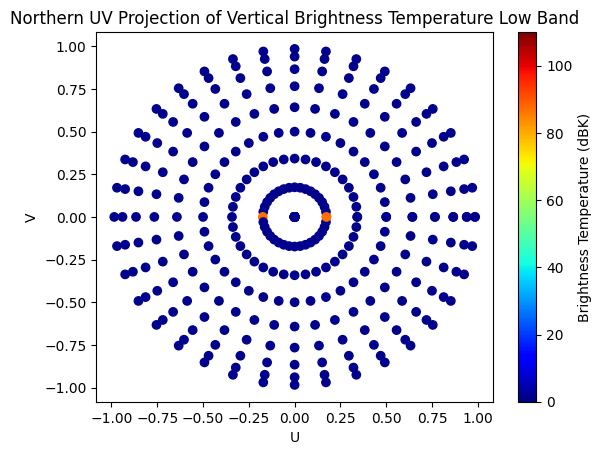

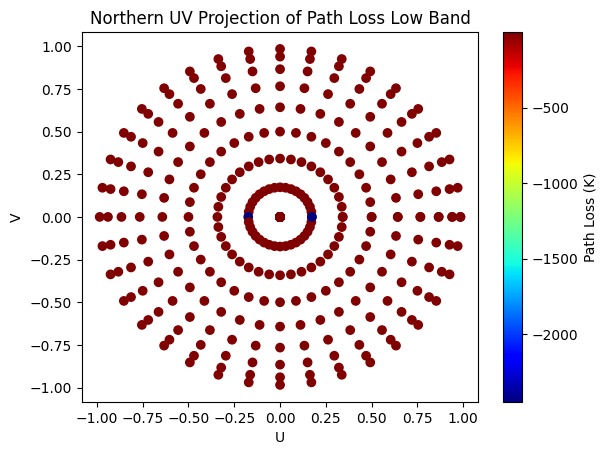

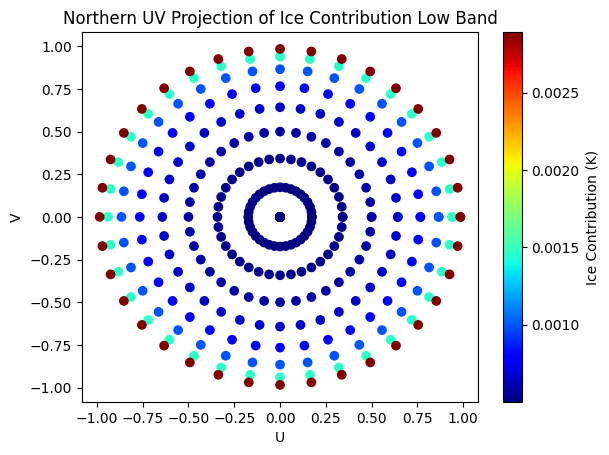

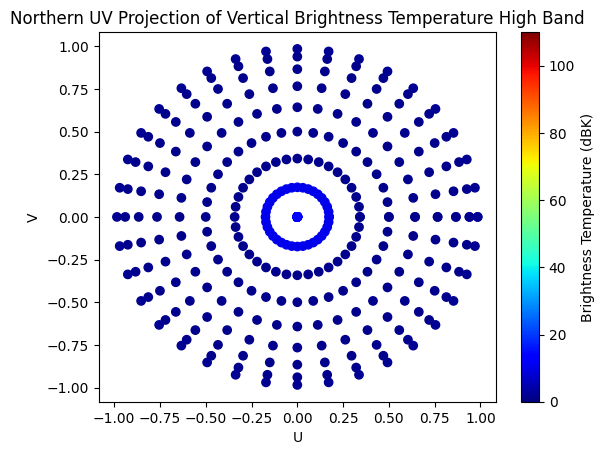

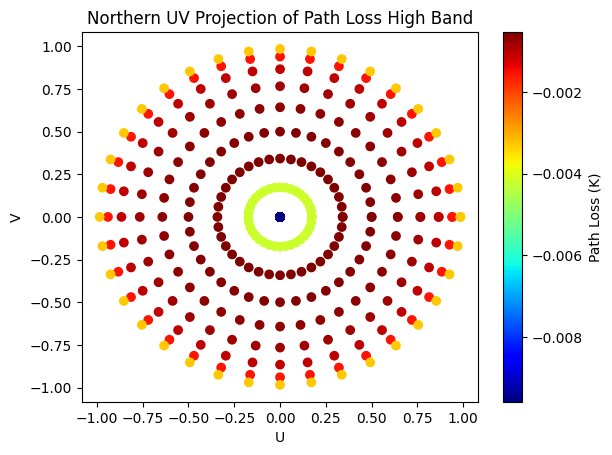

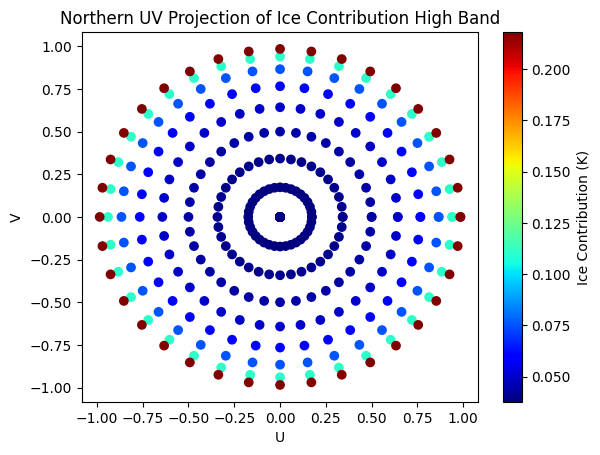

np.int64(1600)

np.float64(483203.94431923196)

np.float64(506.2418676605937)

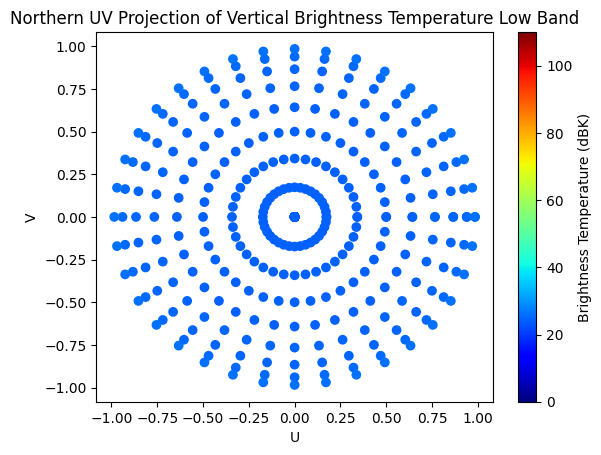

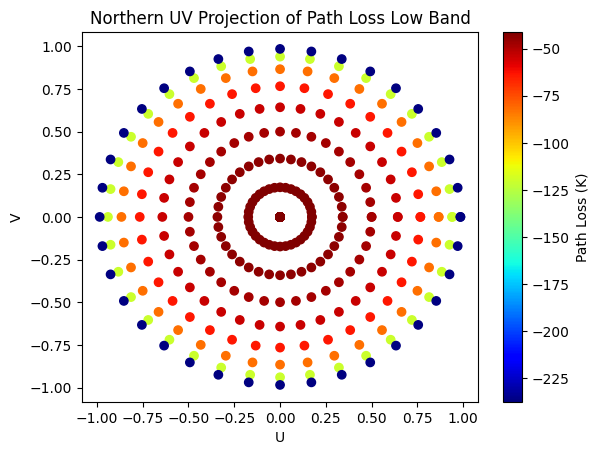

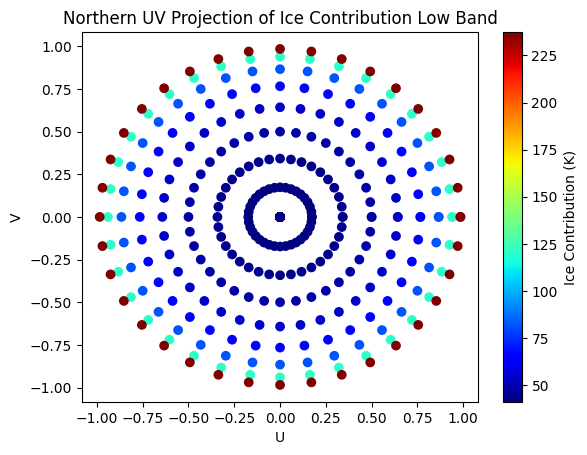

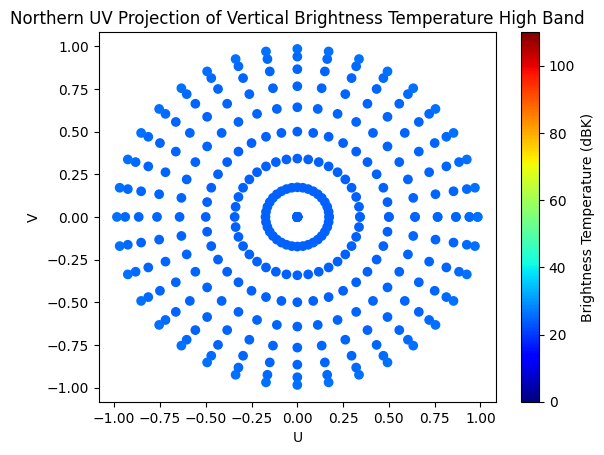

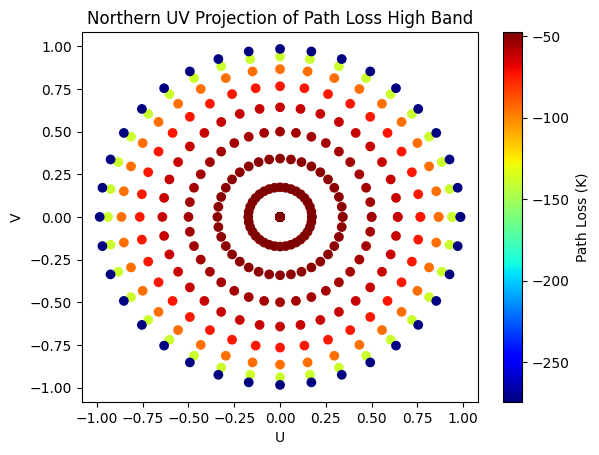

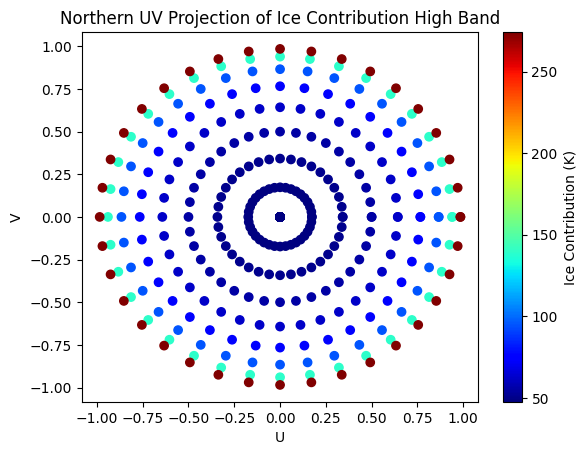

,Depth (m),Temperature (K),Porosity (m^3/m^3),Salt fraction (kg/kg),epsilon_s_prime,epsilon_s_primeprime,sigma_s,T_A Downwelling Low Band (K),T_A Downwelling High Band (K)
0,0.0,104.000000,0.1,0.00001,2.779818,0.000007,4.050878e-11,1.571709e+06,8.038808
1,10.0,104.121154,0.1,0.00001,2.779914,0.000007,4.168254e-11,1.571704e+06,8.163163
2,20.0,104.242308,0.1,0.00001,2.780009,0.000007,4.288747e-11,1.571698e+06,8.287962
3,30.0,104.363462,0.1,0.00001,2.780104,0.000007,4.412431e-11,1.571693e+06,8.413210
4,40.0,104.484615,0.1,0.00001,2.780200,0.000007,4.539383e-11,1.571688e+06,8.538906
...,...,...,...,...,...,...,...,...,...
1616,16160.0,251.600000,0.0,0.00001,3.168808,0.000528,7.731257e-05,4.832039e+05,506.241868
1617,16170.0,251.600000,0.0,0.00001,3.168808,0.000528,7.731257e-05,4.832039e+05,506.241868
1618,16180.0,251.600000,0.0,0.00001,3.168808,0.000528,7.731257e-05,4.832039e+05,506.241868
1619,16190.0,251.600000,0.0,0.00001,3.168808,0.000528,7.731257e-05,4.832039e+05,506.241868


In [31]:
eim = europa_ice_model(
    T_u, 
    T_l, 
    T_melt, 
    T_conv, 
    D_cond, 
    D_phi, 
    eta_vac, 
    rho_salt, 
    D_conv, 
    delta_d
)

mm = mission_model()
ant = antenna()

ag = angle_grid(10, 10)

# Evaluation of the sub-Jovian point on Europa
# Rotate the brightness field pattern so we are standing on the sub-jovian point
T_Bv_low_band, \
    T_Bh_low_band, \
        T_Bv_high_band, \
            T_Bh_high_band \
                = T_B_sub_jovian_point()

# Calculate the downwelling noise stream

def calc_downwelling_noise_stream(
        T_Bh_low_band, T_Bv_low_band, T_Bh_high_band, T_Bv_high_band):
    T_A_low_band = np.zeros(len(eim.cryosphere_model_df))
    T_A_high_band = np.zeros(len(eim.cryosphere_model_df))

    brightness_temperature_horizontal_low_band_at_depth = T_Bh_low_band.flatten().copy()
    brightness_temperature_vertical_low_band_at_depth = T_Bv_low_band.flatten().copy()
    brightness_temperature_horizontal_high_band_at_depth = T_Bh_high_band.flatten().copy()
    brightness_temperature_vertical_high_band_at_depth = T_Bv_high_band.flatten().copy()

    delta_path_loss_high_band = np.ones(ag.theta_grid.flatten().shape)
    delta_path_loss_low_band = np.ones(ag.theta_grid.flatten().shape)

    exp_numerator_high_band = np.ones(ag.theta_grid.flatten().shape)
    exp_numerator_low_band = np.ones(ag.theta_grid.flatten().shape)

    theta_t_values = np.deg2rad(ag.theta_grid.flatten())
    phi_t_values = np.deg2rad(ag.phi_grid.flatten())

    for d in np.arange(len(eim.cryosphere_model_df)):
        epsilon_s_prime = eim.cryosphere_model_df.loc[d]['epsilon_s_prime']
        epsilon_s_primeprime = eim.cryosphere_model_df.loc[d]['epsilon_s_primeprime']
        sigma_s = eim.cryosphere_model_df.loc[d]['sigma_s']
        temperature_ice = eim.cryosphere_model_df.loc[d]['Temperature (K)']

        alpha_high_band = calc_path_loss(mm.high_band_omega, epsilon_s_prime, epsilon_s_primeprime, sigma_s)
        alpha_low_band = calc_path_loss(mm.low_band_omega, epsilon_s_prime, epsilon_s_primeprime, sigma_s)
        for t in np.arange(len(theta_t_values)):
            theta_t = theta_t_values[t]
            phi_t = phi_t_values[t]
            if theta_t < np.pi/2:
                # if theta_t != np.pi / 2:
                exp_numerator_high_band[t] = -2 * (eim.delta_d / np.abs(np.cos(theta_t))) * alpha_high_band
                exp_numerator_low_band[t] = -2 * (eim.delta_d / np.abs(np.cos(theta_t))) * alpha_low_band    

                delta_path_loss_high_band[t] = 1 - np.e**(exp_numerator_high_band[t])
                delta_path_loss_low_band[t] = 1 - np.e**(exp_numerator_low_band[t])
                # else: # Limit of the exponential function above when theta_t is 90 degrees
                #     delta_path_loss_high_band[t] = 1
                #     delta_path_loss_low_band[t] = 1

                #     exp_numerator_high_band[t] = 0
                #     exp_numerator_low_band[t] = 0
            else: # if we are looking down, set the TA contribution of this depth to 0
                exp_numerator_high_band[t] = 0
                exp_numerator_low_band[t] = 0

                delta_path_loss_high_band[t] = 0
                delta_path_loss_low_band[t] = 0

        if d > 0:
            brightness_temperature_horizontal_low_band_at_depth += \
                -1 * delta_path_loss_low_band \
                    * brightness_temperature_horizontal_low_band_at_depth \
                        - exp_numerator_low_band * temperature_ice
            brightness_temperature_vertical_low_band_at_depth += \
                -1 * delta_path_loss_low_band \
                    * brightness_temperature_vertical_low_band_at_depth \
                        - exp_numerator_low_band * temperature_ice
            brightness_temperature_horizontal_high_band_at_depth += \
                -1 * delta_path_loss_high_band \
                    * brightness_temperature_horizontal_high_band_at_depth      \
                        - exp_numerator_high_band * temperature_ice    
            brightness_temperature_vertical_high_band_at_depth += \
                -1 * delta_path_loss_high_band \
                    * brightness_temperature_vertical_high_band_at_depth \
                        - exp_numerator_high_band * temperature_ice 

        # Integrate over antenna directivity to get antenna temperature
        directivity_RHCP_high_band = ant.UHF_directivity_pattern_RHCP
        temp = (brightness_temperature_horizontal_high_band_at_depth \
            + brightness_temperature_vertical_high_band_at_depth).reshape(directivity_RHCP_high_band.shape) * directivity_RHCP_high_band \
            * np.sin(np.deg2rad(ag.theta.flatten()))[:, None]
        temp = scipy.integrate.simpson(
            temp, 
            x=phi_t_values.reshape(directivity_RHCP_high_band.shape))
        T_A_high_band[d] = (1 / (4 * np.pi)) * scipy.integrate.simpson(
            temp, 
            x=theta_t_values.reshape(directivity_RHCP_high_band.shape)[:,0])

        directivity_RHCP_low_band = ant.HF_directivity_pattern_RHCP
        temp = (brightness_temperature_horizontal_low_band_at_depth \
            + brightness_temperature_vertical_low_band_at_depth).reshape(directivity_RHCP_low_band.shape) * directivity_RHCP_low_band \
            * np.sin(np.deg2rad(ag.theta.flatten()))[:, None]
        temp = scipy.integrate.simpson(
            temp, 
            x=phi_t_values.reshape(directivity_RHCP_low_band.shape))
        T_A_low_band[d] = (1 / (4 * np.pi)) * scipy.integrate.simpson(
            temp, 
            x=theta_t_values.reshape(directivity_RHCP_low_band.shape)[:,0])

        if d == 1 or d == 1600:
            display(d, T_A_low_band[d], T_A_high_band[d])
            theta_grid_rad = np.deg2rad(ag.theta_grid)
            phi_grid_rad = np.deg2rad(ag.phi_grid)

            U = (np.sin(theta_grid_rad[0:9]) * np.cos(phi_grid_rad[0:9])).flatten()
            V = (np.sin(theta_grid_rad[0:9]) * np.sin(phi_grid_rad[0:9])).flatten()

            plt.figure()
            plt.scatter(U, V, 
                c=10 * np.log10(brightness_temperature_horizontal_low_band_at_depth.reshape(theta_grid_rad.shape)[0:9].flatten())
                , cmap='jet', vmin=0, vmax=110)
            plt.colorbar(label='Brightness Temperature (dBK)')
            plt.xlabel('U')
            plt.ylabel('V')
            plt.title('Northern UV Projection of Vertical Brightness Temperature Low Band')
            plt.show()

            plt.figure()
            plt.scatter(U, V, 
                c=(-1 * delta_path_loss_low_band \
                * brightness_temperature_horizontal_low_band_at_depth)\
                    .reshape(theta_grid_rad.shape)[0:9].flatten(), cmap='jet')
            plt.colorbar(label='Path Loss (K)')
            plt.xlabel('U')
            plt.ylabel('V')
            plt.title('Northern UV Projection of Path Loss Low Band')
            plt.show()

            plt.figure()
            plt.scatter(U, V, 
                c=(-1 * exp_numerator_low_band * temperature_ice ).reshape(theta_grid_rad.shape)[0:9].flatten()
                , cmap='jet')
            plt.colorbar(label='Ice Contribution (K)')
            plt.xlabel('U')
            plt.ylabel('V')
            plt.title('Northern UV Projection of Ice Contribution Low Band')
            plt.show()

            plt.figure()
            plt.scatter(U, V, 
                c=10 * np.log10(brightness_temperature_horizontal_high_band_at_depth.reshape(theta_grid_rad.shape)[0:9].flatten())
                , cmap='jet', vmin=0, vmax=110)
            plt.colorbar(label='Brightness Temperature (dBK)')
            plt.xlabel('U')
            plt.ylabel('V')
            plt.title('Northern UV Projection of Vertical Brightness Temperature High Band')
            plt.show()

            plt.figure()
            plt.scatter(U, V, 
                c=(-1 * delta_path_loss_high_band \
                * brightness_temperature_horizontal_high_band_at_depth)\
                    .reshape(theta_grid_rad.shape)[0:9].flatten(), cmap='jet')
            plt.colorbar(label='Path Loss (K)')
            plt.xlabel('U')
            plt.ylabel('V')
            plt.title('Northern UV Projection of Path Loss High Band')
            plt.show()

            plt.figure()
            plt.scatter(U, V, 
                c=(-1 * exp_numerator_high_band * temperature_ice ).reshape(theta_grid_rad.shape)[0:9].flatten()
                , cmap='jet')
            plt.colorbar(label='Ice Contribution (K)')
            plt.xlabel('U')
            plt.ylabel('V')
            plt.title('Northern UV Projection of Ice Contribution High Band')
            plt.show()        

    return T_A_low_band, T_A_high_band

T_A_low_band, T_A_high_band = calc_downwelling_noise_stream(T_Bh_low_band, T_Bv_low_band, T_Bh_high_band, T_Bv_high_band)
eim.cryosphere_model_df['T_A Downwelling Low Band (K)'] = T_A_low_band
eim.cryosphere_model_df['T_A Downwelling High Band (K)'] = T_A_high_band

eim.cryosphere_model_df

In [35]:
#DNF

eim = europa_ice_model(
    T_u, 
    T_l, 
    T_melt, 
    T_conv, 
    D_cond, 
    D_phi, 
    eta_vac, 
    rho_salt, 
    D_conv, 
    delta_d
)

mm = mission_model()
ant = antenna()

ag = angle_grid(10, 10)

# Evaluation of the sub-Jovian point on Europa
# Rotate the brightness field pattern so we are standing on the sub-jovian point
T_Bv_low_band, \
    T_Bh_low_band, \
        T_Bv_high_band, \
            T_Bh_high_band \
                = T_B_sub_jovian_point()

# Calculate the downwelling noise stream
T_A_low_band = np.zeros(len(eim.cryosphere_model_df))
T_A_high_band = np.zeros(len(eim.cryosphere_model_df))

depth_indices = len(eim.cryosphere_model_df)
brightness_temperature_horizontal_low_band_at_depth = np.zeros((depth_indices, *ag.theta_grid.shape))
brightness_temperature_horizontal_low_band_at_depth[0] = T_Bh_low_band.copy()
brightness_temperature_vertical_low_band_at_depth = np.zeros((depth_indices, *ag.theta_grid.shape))
brightness_temperature_vertical_low_band_at_depth[0] = T_Bv_low_band.copy()
brightness_temperature_horizontal_high_band_at_depth = np.zeros((depth_indices, *ag.theta_grid.shape))
brightness_temperature_horizontal_high_band_at_depth[0] = T_Bh_high_band.copy()
brightness_temperature_vertical_high_band_at_depth = np.zeros((depth_indices, *ag.theta_grid.shape))
brightness_temperature_vertical_high_band_at_depth[0] = T_Bv_high_band.copy()

delta_path_loss_high_band = np.ones((depth_indices, *ag.theta_grid.shape))
delta_path_loss_low_band = np.ones((depth_indices, *ag.theta_grid.shape))

exp_numerator_high_band = np.ones((depth_indices, *ag.theta_grid.shape))
exp_numerator_low_band = np.ones((depth_indices, *ag.theta_grid.shape))

theta_t_values = np.deg2rad(ag.theta)
phi_t_values = np.deg2rad(ag.phi)

for d in np.arange(len(eim.cryosphere_model_df)):
    epsilon_s_prime = eim.cryosphere_model_df.loc[d]['epsilon_s_prime']
    epsilon_s_primeprime = eim.cryosphere_model_df.loc[d]['epsilon_s_primeprime']
    sigma_s = eim.cryosphere_model_df.loc[d]['sigma_s']
    temperature_ice = eim.cryosphere_model_df.loc[d]['Temperature (K)']

    alpha_high_band = calc_path_loss(mm.high_band_omega, epsilon_s_prime, epsilon_s_primeprime, sigma_s)
    alpha_low_band = calc_path_loss(mm.low_band_omega, epsilon_s_prime, epsilon_s_primeprime, sigma_s)
    for i in np.arange(len(theta_t_values)):
        theta_t = theta_t_values[i]
        for j in np.arange(len(phi_t_values)):
            phi_t = phi_t_values[j]
            if theta_t < np.pi/2:
                exp_numerator_high_band[d, i, j] = -2 * (eim.delta_d / np.abs(np.cos(theta_t))) * alpha_high_band
                exp_numerator_low_band[d, i, j] = -2 * (eim.delta_d / np.abs(np.cos(theta_t))) * alpha_low_band    

                delta_path_loss_high_band[d, i, j] = 1 - np.e**(exp_numerator_high_band[d, i, j])
                delta_path_loss_low_band[d, i, j] = 1 - np.e**(exp_numerator_low_band[d, i, j])
            else: # if we are looking down, set the TA contribution of this depth to 0
                exp_numerator_high_band[d, i, j] = 0
                exp_numerator_low_band[d, i, j] = 0

                delta_path_loss_high_band[d, i, j] = 0
                delta_path_loss_low_band[d, i, j] = 0

    if d > 0:
        brightness_temperature_horizontal_low_band_at_depth[d] += \
            -1 * delta_path_loss_low_band[d] \
                * brightness_temperature_horizontal_low_band_at_depth[d-1] \
                    - exp_numerator_low_band[d] * temperature_ice
        brightness_temperature_vertical_low_band_at_depth[d] += \
            -1 * delta_path_loss_low_band[d] \
                * brightness_temperature_vertical_low_band_at_depth[d-1] \
                    - exp_numerator_low_band[d] * temperature_ice
        brightness_temperature_horizontal_high_band_at_depth[d] += \
            -1 * delta_path_loss_high_band[d] \
                * brightness_temperature_horizontal_high_band_at_depth[d-1]  \
                    - exp_numerator_high_band[d] * temperature_ice    
        brightness_temperature_vertical_high_band_at_depth[d] += \
            -1 * delta_path_loss_high_band[d] \
                * brightness_temperature_vertical_high_band_at_depth[d-1] \
                    - exp_numerator_high_band[d] * temperature_ice 

# Integrate over antenna directivity to get antenna temperature
# High Band
temp = (brightness_temperature_horizontal_high_band_at_depth \
    + brightness_temperature_vertical_high_band_at_depth) * ant.UHF_directivity_pattern_RHCP[None, :, :] \
    * np.sin(theta_t_values)[None, :, None]
temp = scipy.integrate.simpson(
    temp, 
    x=np.repeat(np.deg2rad(ag.phi_grid)[None, :, :], depth_indices, 0))
T_A_high_band = (1 / (4 * np.pi)) * scipy.integrate.simpson(
    temp, 
    x=np.repeat(theta_t_values[None, :], depth_indices, 0))
# Low Band
temp = (brightness_temperature_horizontal_low_band_at_depth \
    + brightness_temperature_vertical_low_band_at_depth) * ant.HF_directivity_pattern_RHCP[None, :, :] \
    * np.sin(theta_t_values)[None, :, None]
temp = scipy.integrate.simpson(
    temp, 
    x=np.repeat(np.deg2rad(ag.phi_grid)[None, :, :], depth_indices, 0))
T_A_low_band = (1 / (4 * np.pi)) * scipy.integrate.simpson(
    temp, 
    x=np.repeat(theta_t_values[None, :], depth_indices, 0))

eim.cryosphere_model_df['T_A Downwelling Low Band (K)'] = T_A_low_band
eim.cryosphere_model_df['T_A Downwelling High Band (K)'] = T_A_high_band

eim.cryosphere_model_df

,Depth (m),Temperature (K),Porosity (m^3/m^3),Salt fraction (kg/kg),epsilon_s_prime,epsilon_s_primeprime,sigma_s,T_A Downwelling Low Band (K),T_A Downwelling High Band (K)
0,0.0,104.000000,0.1,0.00001,2.779818,0.000007,4.050878e-11,1.571709e+06,8.038808
1,10.0,104.121154,0.1,0.00001,2.779914,0.000007,4.168254e-11,-5.329097e+00,0.124354
2,20.0,104.242308,0.1,0.00001,2.780009,0.000007,4.288747e-11,4.007406e-04,0.126858
3,30.0,104.363462,0.1,0.00001,2.780104,0.000007,4.412431e-11,3.764586e-04,0.127441
4,40.0,104.484615,0.1,0.00001,2.780200,0.000007,4.539383e-11,3.783761e-04,0.128025
...,...,...,...,...,...,...,...,...,...
1616,16160.0,251.600000,0.0,0.00001,3.168808,0.000528,7.731257e-05,2.474172e+01,116.517821
1617,16170.0,251.600000,0.0,0.00001,3.168808,0.000528,7.731257e-05,2.474172e+01,116.517821
1618,16180.0,251.600000,0.0,0.00001,3.168808,0.000528,7.731257e-05,2.474172e+01,116.517821
1619,16190.0,251.600000,0.0,0.00001,3.168808,0.000528,7.731257e-05,2.474172e+01,116.517821
